In [2]:
from subgroups.dataloading_ffcv import make_dataloaders
from subgroups.resnet9 import construct_rn9

import numpy as np
import torch
import time

from tqdm.auto import tqdm
from torch.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler

from torch.optim import Adam

from typing import List

from tqdm import tqdm

import matplotlib.pyplot as plt

import wandb

import os

from torch.optim.lr_scheduler import ExponentialLR, StepLR

In [3]:
def full_iteration_ffcv(train_dataset: str = None, test_dataset: str = None, batch_size: int = None, num_workers: int = None, 
                        seed: int = None, alpha: float = None, num_classes: int = None, lr: float = None, epochs: int = None, 
                        momentum: float = None, weight_decay: float = None, label_smoothing: float = None, 
                        length: int = None, get_val_samples: bool = None, no_transform: bool = None,  
                        return_sequential: bool = None, test_batch_size: int = None, optimizer: str = None, gamma: float = None, 
                        step_size: float = None, lr_scheduler: str = None, lr_tta: bool = None) -> tuple:
    
    loaders, _ = make_dataloaders(
        train_dataset=train_dataset, test_dataset=test_dataset, batch_size=batch_size,
        num_workers=num_workers, seed=seed, alpha=alpha, length=length, test_batch_size=test_batch_size, get_val_samples=get_val_samples, no_transform=no_transform, return_sequential=return_sequential,
    )  
        
    model = construct_rn9(num_classes=num_classes).to(memory_format=torch.channels_last).cuda()
    
    average_acc, all_margins = train(
        model, loaders, lr=lr, epochs=epochs, momentum=momentum,
        weight_decay=weight_decay, label_smoothing=label_smoothing,
        optimizer=optimizer, gamma=gamma, step_size=step_size, 
        lr_scheduler=lr_scheduler, lr_tta=lr_tta
    )

    return [average_acc, all_margins, loaders['train'].indices]

def eval_test(model, loader, lr_tta: bool = False):
    model.eval()
    with torch.no_grad():
        temp_acc, N = 0.0, 0.0
        all_margins = []
        for it, (ims, labs) in enumerate(loader['test']):
            with autocast('cuda'):
                out = model(ims)
                if lr_tta:
                    out += model(torch.fliplr(ims))
                    out /= 2

                pred = out.argmax(1).eq(labs)
                total_correct = pred.sum().cpu().item()
                temp_acc+=total_correct/ims.shape[0]
                N+=1

                class_logits = out[torch.arange(out.shape[0]), labs].clone()
                out[torch.arange(out.shape[0]), labs] = -1000
                next_classes = out.argmax(1)
                class_logits -= out[torch.arange(out.shape[0]), next_classes]
                all_margins.append(class_logits.cpu())

    all_margins = torch.cat(all_margins)                
    average_acc = temp_acc/N
    return average_acc, all_margins


def train(model: torch.nn.Module, loader: dict = None, lr: float = None, epochs: int = None, momentum: float = None,
          weight_decay: float = None, label_smoothing: float = None, optimizer: str = None, gamma: float = None, 
          step_size: float = None, lr_scheduler: str = None, lr_tta: bool = None) -> list:
    
    if optimizer=='SGD':
        opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer=='adam':
        opt = Adam(model.parameters(), lr=lr)

    if lr_scheduler=='exponential':
        scheduler = ExponentialLR(opt, gamma=gamma)
    elif lr_scheduler=='step':
        scheduler = StepLR(opt, step_size=step_size, gamma=gamma)

    scaler = GradScaler('cuda')
    
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    model.train()

    for ep in tqdm(range(epochs)):
        
        for it, (ims, labs) in enumerate(loader['train']):
            opt.zero_grad(set_to_none=True)

            with autocast('cuda'):
                out = model(ims)
                loss = loss_fn(out, labs)
            
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        scheduler.step()

        #average_acc, all_margins = eval_test(model, loader, lr_tta=lr_tta)

#        wandb.log({
#                "epoch": ep, 
#                "test_accuracy": average_acc,
#                "event": 'model_update'
#        })
       # model.train()
    
    average_acc, all_margins = eval_test(model, loader, lr_tta=lr_tta)
    #average_acc, all_margins = None, None
    return average_acc, all_margins

### Specify your starting parameters

In [5]:
hyperparameters = {
    "train_dataset": './CIFAR10/cifar10_train_subset_binaryLabels.beton',
    "test_dataset": './CIFAR10/cifar10_val_subset_binaryLabels.beton',
    "batch_size": 32,
    "num_workers": 1, 
    "seed": 1,
    "alpha": 0.1,
    "num_classes": 2,
    "lr": 0.45,
    "epochs": 205,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "label_smoothing": 0.0,
    "test_batch_size": 2000,
    "optimizer": 'SGD',
    "lr_scheduler": 'step',
    "step_size": 60,
    "gamma": 0.25,
    "lr_tta": False, 
    "length": 25000,
    "get_val_samples": False,
    "no_transform": False,
    "return_sequential": False
    }

### Check your signal to noise ratio

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:56<00:00,  3.62it/s]


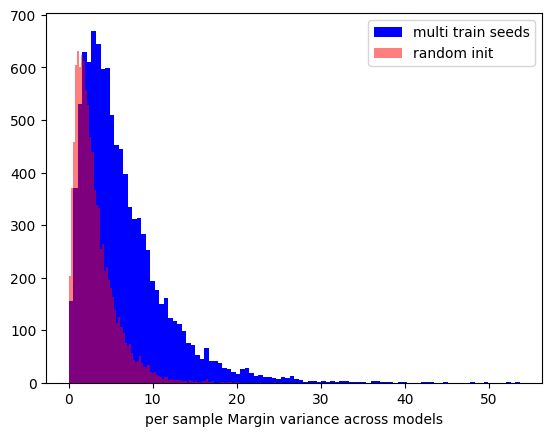

In [6]:
x = []
for i in range(5):

    out = full_iteration_ffcv(train_dataset=hyperparameters['train_dataset'], test_dataset=hyperparameters['test_dataset'], batch_size=hyperparameters['batch_size'], num_workers=hyperparameters['num_workers'], 
                                seed=i, alpha=hyperparameters['alpha'], num_classes=hyperparameters['num_classes'], lr=hyperparameters['lr'], epochs=hyperparameters['epochs'], 
                                momentum=hyperparameters['momentum'], weight_decay=hyperparameters['weight_decay'], label_smoothing=hyperparameters['label_smoothing'], 
                                length=hyperparameters['length'], get_val_samples=hyperparameters['get_val_samples'], no_transform=hyperparameters['no_transform'],  
                                return_sequential=hyperparameters['return_sequential'], test_batch_size=hyperparameters['test_batch_size'], optimizer=hyperparameters['optimizer'], gamma=hyperparameters['gamma'], 
                                step_size=hyperparameters['step_size'], lr_scheduler=hyperparameters['lr_scheduler'], lr_tta=hyperparameters['lr_tta']) 
    x.append(out[1])

x2 = []
for i in range(5):

    out = full_iteration_ffcv(train_dataset=hyperparameters['train_dataset'], test_dataset=hyperparameters['test_dataset'], batch_size=hyperparameters['batch_size'], num_workers=hyperparameters['num_workers'], 
                                seed=0, alpha=hyperparameters['alpha'], num_classes=hyperparameters['num_classes'], lr=hyperparameters['lr'], epochs=hyperparameters['epochs'], 
                                momentum=hyperparameters['momentum'], weight_decay=hyperparameters['weight_decay'], label_smoothing=hyperparameters['label_smoothing'], 
                                length=hyperparameters['length'], get_val_samples=hyperparameters['get_val_samples'], no_transform=hyperparameters['no_transform'],  
                                return_sequential=hyperparameters['return_sequential'], test_batch_size=hyperparameters['test_batch_size'], optimizer=hyperparameters['optimizer'], gamma=hyperparameters['gamma'], 
                                step_size=hyperparameters['step_size'], lr_scheduler=hyperparameters['lr_scheduler'], lr_tta=hyperparameters['lr_tta']) 
    x2.append(out[1])

plt.hist([np.var([x[i][s] for i in range(len(x))]) for s in range(10000)], bins = 100, color='blue', label = 'multi train seeds')
plt.hist([np.var([x2[i][s] for i in range(len(x2))]) for s in range(10000)], alpha = 0.5, bins = 100, color = 'red', label = 'random init')
plt.xlabel('per sample Margin variance across models')
plt.legend()
None

### - Tune your hyperparameters, visualize using wandb


In [7]:
# with wandb
def full_iteration_ffcv(train_dataset: str = None, test_dataset: str = None, batch_size: int = None, num_workers: int = None, 
                        seed: int = None, alpha: float = None, num_classes: int = None, lr: float = None, epochs: int = None, 
                        momentum: float = None, weight_decay: float = None, label_smoothing: float = None, 
                        length: int = None, get_val_samples: bool = None, no_transform: bool = None, set_seed: bool = None, 
                        return_sequential: bool = None, test_batch_size: int = None, optimizer: str = None, gamma: float = 0.99, step_size: float = None, 
                        lr_scheduler: str = None, p_dropout: float = 0) -> tuple:
    
    loaders, train_indices = make_dataloaders(
        train_dataset=train_dataset, test_dataset=test_dataset, batch_size=batch_size,
        num_workers=num_workers, seed=seed, alpha=alpha, length=length, test_batch_size=test_batch_size, get_val_samples=get_val_samples, no_transform=no_transform, return_sequential=return_sequential,
    ) # the val dataloader should return a larger batch
    
    print(train_indices[:50])

    if set_seed:
        torch.manual_seed(42)          
        torch.cuda.manual_seed(42)
         
        
    model = construct_rn9(num_classes=num_classes).to(memory_format=torch.channels_last).cuda()
    print("Initial model weights:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.data}")
    
    train(
        model, loaders, lr=lr, epochs=epochs, momentum=momentum,
        weight_decay=weight_decay, label_smoothing=label_smoothing,
        optimizer=optimizer, gamma=gamma, step_size=step_size, lr_scheduler=lr_scheduler
    )


def eval_test(model, loader, loss_fn):
    model.eval()
    with torch.no_grad():
        temp_loss = 0
        temp_acc = 0
        N = 0
        for it, (ims, labs) in enumerate(loader['test']):
            with autocast('cuda'):
                out = model(ims)
                loss = loss_fn(out, labs)
                pred = out.argmax(1).eq(labs)
                total_correct = pred.sum().cpu().item()
                temp_loss+=loss.item()
                temp_acc+=total_correct/ims.shape[0]
                N+=1
    average_loss, average_acc = temp_loss/N, temp_acc/N
    model.train()
    return average_loss, average_acc


def train(model: torch.nn.Module, loader: dict = None, lr: float = None, epochs: int = None, momentum: float = None,
          weight_decay: float = None, label_smoothing: float = None, optimizer: str = None, gamma: float = 0.99, step_size: float = None, lr_scheduler: str = None) -> dict:
    
    if optimizer=='SGD':
        opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer=='adam':
        opt = Adam(model.parameters(), lr=lr)

    if lr_scheduler=='exponential':
        scheduler = ExponentialLR(opt, gamma=gamma)
    elif lr_scheduler=='step':
        scheduler = StepLR(opt, step_size=step_size, gamma=gamma)


    #iters_per_epoch = len(loader['train'])
    #lr_peak_epoch = 62
    # Cyclic LR with single triangle
    #lr_schedule = np.interp(np.arange((epochs+1) * iters_per_epoch),
    #                        [0, lr_peak_epoch * iters_per_epoch, epochs * iters_per_epoch],
    #                        [0, 1, 0])
    #scheduler = lr_scheduler.LambdaLR(opt, lr_schedule.__getitem__)

    scaler = GradScaler('cuda')
    
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    model.train()

    for ep in tqdm(range(epochs)):
        
        for it, (ims, labs) in enumerate(loader['train']):
            opt.zero_grad(set_to_none=True)

            with autocast('cuda'):
                out = model(ims)
                loss = loss_fn(out, labs)
                pred = out.argmax(1).eq(labs)
                total_correct = pred.sum().cpu().item()
                train_loss, train_accuracy = loss.item(), total_correct/ims.shape[0]
            
            if (it % epochs)==0:
                test_loss, test_accuracy = eval_test(model, loader, loss_fn)
            else:
                test_loss, test_accuracy = None, None

            wandb.log({
                "epoch": ep,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "test_loss": test_loss,
                "test_accuracy": test_accuracy,
                "event": 'model_update'
            })
            
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        scheduler.step()
   



In [8]:
def run_experiment(name, ID, values, run_name):
    hyperparameters = {
        "train_dataset": '/home/gridsan/djuna/TsaiMadry_shared/datamodels_clustering/CIFAR10/cifar10_train_subset_binaryLabels.beton',
        "test_dataset": '/home/gridsan/djuna/TsaiMadry_shared/datamodels_clustering/CIFAR10/cifar10_val_subset_binaryLabels.beton',
        "batch_size": 32,
        "num_workers": 1, 
        "seed": 5,
        "alpha": 0.1,
        "num_classes": 2,
        "lr": 0.45,
        "epochs": 200,#300,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "label_smoothing": 0.0,
        "set_seed": False,
        "test_batch_size": 2000,
        "optimizer": 'SGD',
        "lr_scheduler": 'step',
        "step_size": 60,
        "gamma": 0.25, #0.25,
        "p_dropout": 0
    }

    outdir = f"/home/gridsan/djuna/TsaiMadry_shared/datamodels_clustering/wandb_logs/Experiment_{name}" 
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    hyperparameters[name] = values[ID]

    # Initialize wandb with the hyperparameters
    wandb.init(
        project="cifar10_binary",
        name=f"{name}_{values[ID]}",
        group=f"Experiment_{run_name}",
        config=hyperparameters,
        mode="offline",  # Ensure offline mode is enabled
        dir=outdir # Optional: specify log directory
    )

    config = wandb.config
    full_iteration_ffcv(config.train_dataset, config.test_dataset, batch_size=config.batch_size, 
                        seed=config.seed, alpha=config.alpha, num_classes=config.num_classes, 
                        lr=config.lr, epochs=config.epochs, momentum=config.momentum, 
                        weight_decay=config.weight_decay, label_smoothing=config.label_smoothing, 
                        test_batch_size=config.test_batch_size, optimizer=config.optimizer,
                        set_seed = config.set_seed, gamma = config.gamma, 
                        lr_scheduler = config.lr_scheduler, step_size = config.step_size, 
                        length=25000, get_val_samples=False, no_transform=False, 
                        num_workers=1, return_sequential=False, p_dropout = config.p_dropout) 

    try:
        wandb.finish()
    except KeyboardInterrupt:
        wandb.finish()


In [9]:
for i in range(2):
    run_experiment('seed', i, [0,0,0,0,0], 'best_diff_init_seeds shorter (same init)')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


[  5   9  26  27  38  67  71  73  77  78  87  90  91  94  95  97 103 107
 116 122 138 145 156 163 171 177 178 187 194 198 206 218 220 239 241 247
 252 275 278 279 282 297 308 330 349 350 357 368 382 393]
Initial model weights:
0.0.weight: tensor([[[[-0.0972,  0.0900, -0.1326],
          [-0.0078, -0.1856, -0.0831],
          [-0.0999, -0.1356,  0.0071]],

         [[ 0.0200,  0.0469,  0.0839],
          [ 0.1775, -0.0488,  0.0517],
          [-0.1458,  0.1854, -0.0844]],

         [[ 0.1036, -0.0884,  0.1442],
          [-0.0890,  0.1085, -0.0634],
          [-0.1787, -0.0818, -0.1276]]],


        [[[-0.0505, -0.1637, -0.0558],
          [ 0.1473,  0.1602,  0.1162],
          [ 0.0128,  0.0547, -0.0157]],

         [[ 0.0924,  0.1915,  0.0686],
          [ 0.0435,  0.1749, -0.0623],
          [ 0.1249,  0.1459, -0.1371]],

         [[ 0.1189, -0.1699,  0.1446],
          [ 0.1534,  0.1593, -0.0559],
          [ 0.1227, -0.1736, -0.1084]]],


        [[[ 0.0468, -0.0588, -0.0043],
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:41<00:00,  1.97it/s]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test_accuracy,▅▅▅▅▅▆▁▆▃▆▇▆▇▇▇▆▇█▇▇▇▇██████▇███▇██▇████
test_loss,█▄▃▃▄▃▃▃▂▆▂▃▃▂▂▁▁▂▂▂▃▁▃▁▁▁▁▂▁▂▂▂▂▂▂▂▁▁▁▂
train_accuracy,▃▄▃▅▁█▄▄▃▃▅█▇▅▇▆▅▄▇▆▆▇▄▆██▇█▇██████▇████
train_loss,▄▆█▅▅▇▅▇▄▆▆▅▃▇▅▄▃▄▆▅▄▅▅▃▄▆▃▂▂▁▂▂▅▁▂▃▂▁▃▁
epoch,199
event,model_update
train_accuracy,0.96875
train_loss,0.03103


[  5   9  26  27  38  67  71  73  77  78  87  90  91  94  95  97 103 107
 116 122 138 145 156 163 171 177 178 187 194 198 206 218 220 239 241 247
 252 275 278 279 282 297 308 330 349 350 357 368 382 393]
Initial model weights:
0.0.weight: tensor([[[[ 0.0309, -0.1148, -0.1857],
          [-0.0242,  0.0949,  0.1518],
          [-0.1508, -0.1182,  0.1801]],

         [[ 0.1701, -0.1021,  0.1673],
          [ 0.0647, -0.0378,  0.1059],
          [-0.0526, -0.0031, -0.1764]],

         [[ 0.0319, -0.1768,  0.0601],
          [ 0.0126,  0.0306,  0.1360],
          [-0.1224,  0.0473, -0.1851]]],


        [[[-0.0987,  0.1626, -0.0029],
          [-0.1364, -0.1714,  0.0228],
          [ 0.0165, -0.0104, -0.0809]],

         [[-0.1820, -0.1516,  0.1171],
          [-0.0065,  0.1243, -0.0491],
          [-0.1492,  0.0758,  0.1216]],

         [[ 0.0919, -0.1885, -0.0146],
          [-0.0023,  0.0722,  0.1059],
          [-0.1713, -0.0600, -0.1658]]],


        [[[ 0.1831,  0.1503,  0.1573],
    

 36%|██████████████████████████████████████████████████                                                                                         | 72/200 [00:31<00:53,  2.39it/s]

: 